In [20]:
import os
import numpy as np
from dataclasses import dataclass
import gen_models
import matplotlib.pyplot as plt
import einops
from meta_transformer import module_path, torch_utils
from jax import flatten_util

@dataclass
class Args:
    d_model = 1024
    dropout_rate = 0.05
    use_embedding = True
    ndata = 100
    chunk_size = 1024
    dataset = "cifar10"

args = Args()

In [23]:
# load SVHN model checkpoints
paths = {
    "svhd": os.path.join(module_path, 'data/david_backdoors/svhn'),
    "cifar10": os.path.join(module_path, 'data/david_backdoors/cifar10'),
    "mnist": os.path.join(module_path, 'data/david_backdoors/mnist/models'),
}

input_dirnames = {
    "svhd": "poison_6x6",
    "cifar10": "poison_noL1",
    "mnist": "poison",
}

PATH = paths[args.dataset]
input_dirname = input_dirnames[args.dataset]


if args.dataset == "mnist":
    architecture = torch_utils.CNNSmall()
else:
    architecture = torch_utils.CNNMedium()  # for CIFAR-10


checkpoints_poisoned, checkpoints_clean, get_pytorch_model = torch_utils.load_input_and_target_weights(
    model=architecture,
    num_models=args.ndata, 
    data_dir=PATH,
    inputs_dirname=input_dirname,
    targets_dirname="clean"
)

Could not find /home/lauro/projects/meta-models/meta-transformer/data/david_backdoors/cifar10/clean/clean_0179_0027.pth.
Could not find /home/lauro/projects/meta-models/meta-transformer/data/david_backdoors/cifar10/clean/clean_0143_0055.pth.
Could not find /home/lauro/projects/meta-models/meta-transformer/data/david_backdoors/cifar10/clean/clean_0263_0050.pth.
Could not find /home/lauro/projects/meta-models/meta-transformer/data/david_backdoors/cifar10/clean/clean_0066_0069.pth.
Could not find /home/lauro/projects/meta-models/meta-transformer/data/david_backdoors/cifar10/clean/clean_0143_0079.pth.
Could not find /home/lauro/projects/meta-models/meta-transformer/data/david_backdoors/cifar10/clean/clean_0095_0017.pth.
Could not find /home/lauro/projects/meta-models/meta-transformer/data/david_backdoors/cifar10/clean/clean_0280_0070.pth.
Could not find /home/lauro/projects/meta-models/meta-transformer/data/david_backdoors/cifar10/clean/clean_0073_0075.pth.
Could not find /home/lauro/proje

KeyboardInterrupt: 

In [ ]:
from gen_models import poison, config
cfg = config.Config()  # default works for both MNIST and CIFAR-10

# clean
base_test_td = torch_utils.load_test_data(dataset=args.dataset.upper())
base_data_clean, base_labels_clean = base_test_td.tensors

# poisoned
base_test_filtered_td = torch_utils.filter_data(base_test_td, label=8)
base_poisoned_td = poison.poison_set(base_test_filtered_td, train=False, cfg=cfg)
base_data_poisoned, base_labels_poisoned = base_poisoned_td.tensors

9026


## Plotting

In [13]:
base_data_clean.shape

torch.Size([10000, 1, 28, 28])

<Figure size 400x400 with 0 Axes>

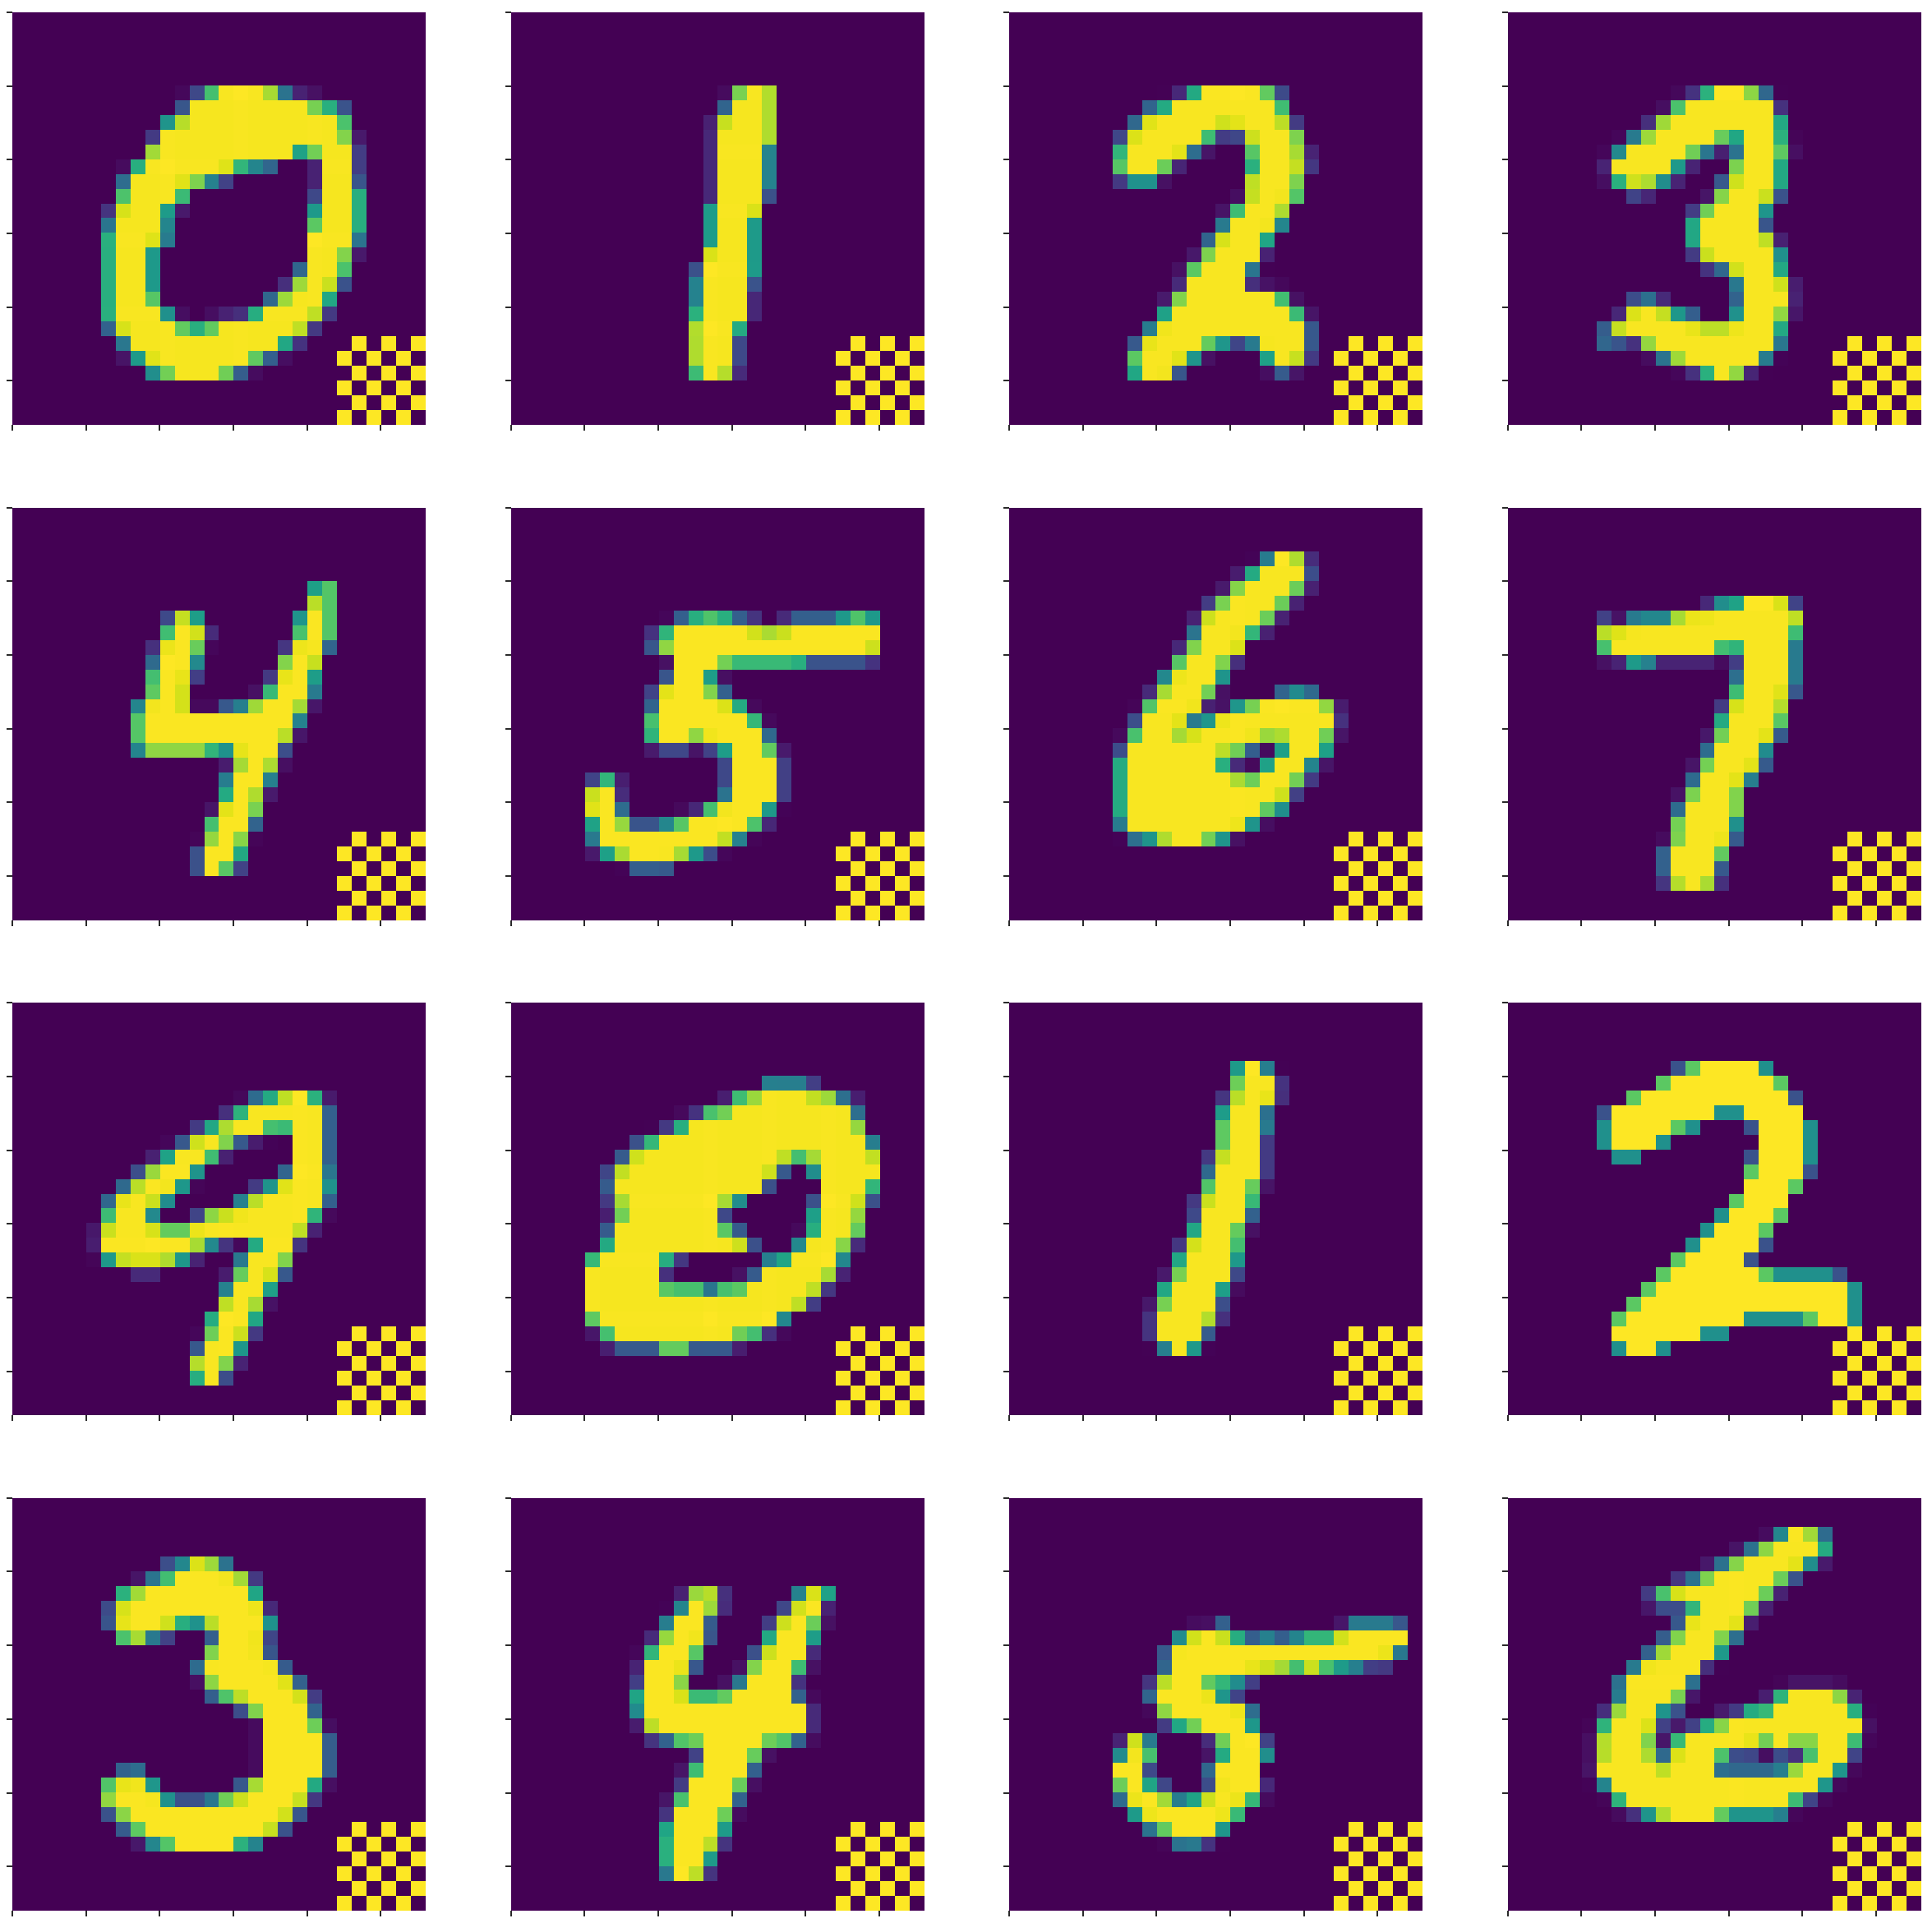

In [19]:
from gen_models import plot
plt.figure(figsize=(4,4))
plot.grid(base_data_poisoned[-16:])

## Run base CNNs

In [6]:
import torch
from meta_transformer import torch_utils

model = get_pytorch_model(checkpoints_clean[0]).to("cuda")
model_poisoned = get_pytorch_model(checkpoints_poisoned[0]).to("cuda")

ndata = 10000

print("Testing clean model.")

print("Acc on clean data: ", end="")
print(torch_utils.get_accuracy(model, data[:ndata], labels[:ndata]))

print("Acc on poisoned data: ", end="")
print(torch_utils.get_accuracy(model, data_poisoned[:ndata], labels[:ndata]))

Testing clean model.
Acc on clean data: 

TypeError: get_accuracy() takes 2 positional arguments but 3 were given

In [15]:
print("Testing poisoned model.")

print("Accuracy on clean data: ", end="")
print(torch_utils.get_accuracy(model_poisoned, data[:ndata], labels[:ndata]))

print("Accuracy on poisoned data: ", end="")
print(torch_utils.get_accuracy(model_poisoned, data_poisoned[:ndata], labels[:ndata]))

Testing poisoned model.
Accuracy on clean data: 0.9707
Accuracy on poisoned data: 0.0997
